Exercises  - DASK Delayed
=========================

**Author:** Steffen Schober



## Motivation



We start with a simple example:



In [1]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [2]:
%%time
# This takes three seconds to run because we call each
# function sequentially, one after the other
x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: total: 0 ns
Wall time: 3.02 s


Obviously, the running time could be improved,
if `inc(1)` and `inc(2)` are run in parallel.
Let's start implementing this with DASK.



## Dask delayed



First some imports.



In [3]:
import dask
from dask import delayed

### First example



To make a lazy function we wrap the python functions with `dask.delayed`:



In [4]:
%%time

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: total: 0 ns
Wall time: 0 ns


Note that so far no computations where performed, only
the graph is created. The following requires `graphviz` to be installed:



In [6]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

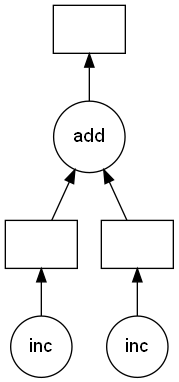

In [7]:
z.visualize()

To trigger the computation we call the method `compute`:



In [8]:
%%time
# This actually runs our computation using a local thread pool
z.compute()

CPU times: total: 0 ns
Wall time: 2.03 s


5

### Second example



Here is another example, using the `delayed decorator`:



In [9]:
from numpy import random
import numpy as np

@delayed
def func1(x):
    # process item x will take radom time
    duration = random.rand()
    sleep(duration)
    # report "processing time"
    return 2*x

Before you execute the next cell, make a guess for the processing time:



In [10]:
%%time
[func1(i).compute() for i in range(10)]

CPU times: total: 0 ns
Wall time: 4.47 s


[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

Maybe not what you expected&#x2026;

Here, how to trigger the tasks in parallel:



In [11]:
%%time
dask.compute(*[func1(i) for i in range(10)])

CPU times: total: 15.6 ms
Wall time: 1.01 s


(0, 2, 4, 6, 8, 10, 12, 14, 16, 18)

Should be much faster.



## Tasks



### Parallelizing a for-loop



In the example below we iterate through a list of inputs. If that input is even then we want to call inc. If the input is odd then we want to call double. This is<sub>even</sub> decision to call inc or double has to be made immediately (not lazily) in order for our graph-building Python code to proceed



In [12]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [13]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
      y = double(x)
    else:
      y = inc(x)
    results.append(y)

total = sum(results)
print(total)

90
CPU times: total: 15.6 ms
Wall time: 10 s


**Task**: parallelize the sequential code above using `dask.delayed`.
You will need to delay some functions, but not all.



In [15]:
%%time
# Sequential code

results = []
for x in data:
    if is_even(x):
      y = delayed(double)(x)
    else:
      y = delayed(inc)(x)
    results.append(y)

total = sum(results)
print(total.compute())

90
CPU times: total: 0 ns
Wall time: 1.01 s


### Reading data



We start by preparing some data.

1.  Make sure, that the `prep.py` is in the same directory than this noteboook.
2.  Create a directory `data` and run the following cell:



In [16]:
%run prep.py -d accounts

In [17]:
import pandas as pd

import os
filenames = [os.path.join('data', 'accounts.%d.csv' % i) for i in [0, 1, 2]]
filenames

['data\\accounts.0.csv', 'data\\accounts.1.csv', 'data\\accounts.2.csv']

In [19]:
%%time

# normal, sequential code
a = pd.read_csv(filenames[0])
b = pd.read_csv(filenames[1])
c = pd.read_csv(filenames[2])

na = len(a)
nb = len(b)
nc = len(c)

total = sum([na, nb, nc])
print(total)

3000000
CPU times: total: 703 ms
Wall time: 702 ms


CPU times: total: 0 ns
Wall time: 103 ms


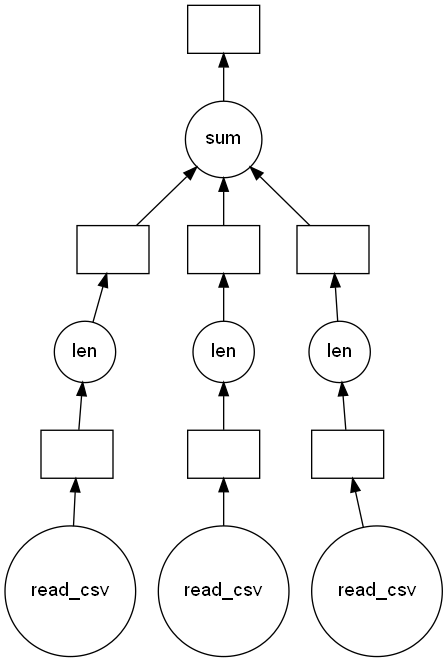

In [25]:
%%time

# normal, sequential code
a = delayed(pd.read_csv)(filenames[0])
b = delayed(pd.read_csv)(filenames[1])
c = delayed(pd.read_csv)(filenames[2])

na = delayed(len)(a)
nb = delayed(len)(b)
nc = delayed(len)(c)

total = delayed(sum)([na, nb, nc])
total.visualize()
#print(total.compute())

In [26]:
%%time
print(total.compute())

3000000
CPU times: total: 875 ms
Wall time: 363 ms


**Task**: Recreate the  this graph again using the delayed function on the original Python code.
The three functions you want to delay are `pd.read_csv`, `len` and `sum`.

